In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR
from torchvision.datasets import MNIST, FashionMNIST, CIFAR10, STL10
import os
import pickle
import zipfile
import datetime

import matplotlib.pyplot as plt

In [2]:
CUDA_LAUNCH_BLOCKING=1

In [3]:
batch_size = 64
def load_data():
    data_transform = transforms.Compose([transforms.ToTensor()])
    train_data = CIFAR10(root="./data", train=True, transform=data_transform, download=True)
    test_data = CIFAR10(root="./data", train=False, transform=data_transform, download=True)

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=0)

    return train_data, test_data, train_loader, test_loader

In [4]:
class EncoderModule(nn.Module):
    def __init__(self, input_channels, output_channels, stride, kernel, pad):
        super().__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=kernel, padding=pad, stride=stride)
        self.pool = nn.MaxPool2d(3, stride=2)
        self.bn = nn.BatchNorm2d(output_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

In [5]:
class Encoder(nn.Module):
    def __init__(self, color_channels, pooling_kernels, n_neurons_in_middle_layer):
        self.n_neurons_in_middle_layer = n_neurons_in_middle_layer
        super().__init__()
        self.bottle = EncoderModule(color_channels, 32, stride=1, kernel=3, pad=1)
        self.m1 = EncoderModule(32, 64, stride=2, kernel=3, pad=1)
        self.m2 = EncoderModule(64, 128, stride=pooling_kernels[0], kernel=1, pad=1)
        self.m3 = EncoderModule(128, 256, stride=pooling_kernels[1], kernel=3, pad=1)
#         self.m4 = EncoderModule(256, 512, stride=3, kernel=5, pad=1)
#         self.m5 = EncoderModule(512, 1024, stride=1, kernel=3, pad=0)
        

    def forward(self, x):
        out = self.bottle(x)
#         print(out.shape)
        
        out = self.m1(out)
#         print(out.shape)
        
        out = self.m2(out)
#         print(out.shape)
        
        out = self.m3(out)
#         print(out.shape)
        
#         out = self.m4(out)
#         print(out.shape)
        
#         out = self.m5(out)
#         print('final', out.shape)
        return out.view(-1, self.n_neurons_in_middle_layer)

In [6]:
class DecoderModule(nn.Module):
    def __init__(self, input_channels, output_channels, stride, kernel, pad, output_size=None, activation="relu"):
        super().__init__()
        self.output_size = output_size 
        self.convt = nn.ConvTranspose2d(input_channels, output_channels, kernel_size=kernel, padding=pad, stride=stride)
        self.bn = nn.BatchNorm2d(output_channels)
        if activation == "relu":
            self.activation = nn.ReLU(inplace=True)
        elif activation == "sigmoid":
            self.activation = nn.Sigmoid()

    def forward(self, x):
        x = self.convt(x)
            
        return self.activation(self.bn(x))

In [7]:
class Decoder(nn.Module):
    def __init__(self, color_channels, pooling_kernels, decoder_input_size):
        self.decoder_input_size = decoder_input_size
        super().__init__()
#         self.m00 = DecoderModule(1024, 512, stride=1, kernel=3, pad=0)
#         self.m0 = DecoderModule(512, 256, stride=3, kernel=5, pad=1)
        self.m1 = DecoderModule(256, 128, stride=pooling_kernels[1], kernel=3, pad=1)
        self.m2 = DecoderModule(128, 64, stride=pooling_kernels[0], kernel=2, pad=1)
        self.m3 = DecoderModule(64, 32, stride=2, kernel=4, pad=1)
        self.bottle = DecoderModule(32, color_channels, stride=1, kernel=3, pad=1, activation="sigmoid")

    def forward(self, x):
        out = x.view(-1, 256, self.decoder_input_size, self.decoder_input_size)
#         print(out.shape)
#         out = self.m00(out)
#         print(out.shape)
#         out = self.m0(out)
#         print(out.shape)
        
        out = self.m1(out)
#         print(out.shape)
        
        out = self.m2(out)
#         print(out.shape)
        
        out = self.m3(out)
#         print(out.shape)
        out = self.bottle(out)
#         print(out.shape)
        
        return out

In [8]:
#data
train_data, test_daata, train_loader, test_loader = load_data()

Files already downloaded and verified
Files already downloaded and verified


In [9]:
class VAE(nn.Module):
    def __init__(self):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
#         self.device ='cpu' 

        super().__init__()
        
        ## number of latent features 
        self.num_latent_features = 64

        pooling_kernel = [2, 2]
        encoder_output_size = 5
        color_channels = 3

        num_neurons_in_middle_layer = 256 * encoder_output_size * encoder_output_size

        #Encoder
        self.encoder = Encoder(color_channels, pooling_kernel, num_neurons_in_middle_layer)
        #Middle
        self.fc1 = nn.Linear(num_neurons_in_middle_layer, self.num_latent_features)
        self.fc2 = nn.Linear(num_neurons_in_middle_layer, self.num_latent_features)
        self.fc3 = nn.Linear(self.num_latent_features, num_neurons_in_middle_layer)
        #Decoder
        self.decoder = Decoder(color_channels, pooling_kernel, encoder_output_size)

        #loss history 
        self.history = {"train_loss": [], "val_loss": []}

        if not os.path.exists('cifar'):
            os.mkdir('cifar')

    def _reparameterize(self, mu, logvar): 
        std = logvar.mul(0.5).exp_()
        exp = torch.randn(*mu.size()).to(self.device)
        z = mu + std * exp
        return z
      
    def _bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self._reparameterize(mu, logvar)
        return z, mu, logvar

    def forward(self, x):
        #Encoder
#         import ipdb; ipdb.set_trace()
        
        h = self.encoder(x)
        #Bottleneck
        z, mu, logvar = self._bottleneck(h)
        #decoder
        z = self.fc3(z)
        d = self.decoder(z)
        return d, mu, logvar 

    def loss_function(self, recon_x, x, mu, logvar):
#         import ipdb; ipdb.set_trace()
        bce = F.binary_cross_entropy(recon_x, x, size_average=False)
        kld = - 0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return bce + kld

    def init_model(self):
        self.optimizer = optim.Adam(self.parameters(), lr=1e-4)
        self.scheduler = CosineAnnealingLR(self.optimizer, 100)

        if self.device == "cuda":
            self = self.cuda()
            torch.backends.cudnn.benchmark = True
        self.to(self.device)

    # Train
    def fit_train(self, epoch):
        self.train()
        print(f"\nEpoch: {epoch + 1: d} {datetime.datetime.now()}")
        train_loss = 0
        samples_count = 0
        for batch_idx, (inputs, _) in enumerate(train_loader):
            inputs = inputs.to(self.device)
            self.optimizer.zero_grad()
            recon_batch, mu, logvar = self(inputs)

            loss = self.loss_function(recon_batch, inputs, mu, logvar)
            loss.backward()
            self.optimizer.step()
            self.scheduler.step()

            train_loss += loss.item()
            samples_count += inputs.size(0)

            if batch_idx % 50 == 0:
                print(f"Train batch index: {batch_idx}, dataset size: {len(train_loader)}, Loss: {train_loss/samples_count:f}")

        self.history["train_loss"].append(train_loss/samples_count)

    def test(self, epoch):
        self.eval()
        val_loss = 0
        samples_count = 0
        with torch.no_grad():
            for batch_idx, (inputs, _) in enumerate(test_loader): 
                inputs = inputs.to(self.device)
                recon_batch, mu, logvar = self(inputs)
                val_loss += self.loss_function(recon_batch, inputs, mu, logvar).item()
                samples_count += inputs.size(0)

        print(f"Test batch index: {batch_idx}, dataset size: {len(test_loader)}, Val Loss: {val_loss/samples_count:f}") 
        self.history["val_loss"].append(val_loss/samples_count)

In [10]:
net = VAE()

In [11]:
net

VAE(
  (encoder): Encoder(
    (bottle): EncoderModule(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (m1): EncoderModule(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (m2): EncoderModule(
      (conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)

In [12]:
net.init_model()

In [15]:
for i in range(30):
    net.fit_train(i)
    net.test(i)


Epoch:  1 2022-03-12 14:12:26.316683
Train batch index: 0, dataset size: 782, Loss: 1819.707886
Train batch index: 50, dataset size: 782, Loss: 1815.261592
Train batch index: 100, dataset size: 782, Loss: 1819.585563
Train batch index: 150, dataset size: 782, Loss: 1820.203940
Train batch index: 200, dataset size: 782, Loss: 1820.529242
Train batch index: 250, dataset size: 782, Loss: 1821.757585
Train batch index: 300, dataset size: 782, Loss: 1822.825901
Train batch index: 350, dataset size: 782, Loss: 1822.540161
Train batch index: 400, dataset size: 782, Loss: 1822.868608
Train batch index: 450, dataset size: 782, Loss: 1821.917187
Train batch index: 500, dataset size: 782, Loss: 1821.188317
Train batch index: 550, dataset size: 782, Loss: 1821.313763
Train batch index: 600, dataset size: 782, Loss: 1821.369391
Train batch index: 650, dataset size: 782, Loss: 1820.953823
Train batch index: 700, dataset size: 782, Loss: 1821.009010
Train batch index: 750, dataset size: 782, Loss: 1

Train batch index: 550, dataset size: 782, Loss: 1820.830331
Train batch index: 600, dataset size: 782, Loss: 1820.532178
Train batch index: 650, dataset size: 782, Loss: 1820.614350
Train batch index: 700, dataset size: 782, Loss: 1820.657033
Train batch index: 750, dataset size: 782, Loss: 1820.539304
Test batch index: 156, dataset size: 157, Val Loss: 1820.326922

Epoch:  9 2022-03-12 14:15:26.921983
Train batch index: 0, dataset size: 782, Loss: 1815.991943
Train batch index: 50, dataset size: 782, Loss: 1820.094248
Train batch index: 100, dataset size: 782, Loss: 1817.761438
Train batch index: 150, dataset size: 782, Loss: 1818.259585
Train batch index: 200, dataset size: 782, Loss: 1817.840882
Train batch index: 250, dataset size: 782, Loss: 1818.520061
Train batch index: 300, dataset size: 782, Loss: 1818.550574
Train batch index: 350, dataset size: 782, Loss: 1818.836153
Train batch index: 400, dataset size: 782, Loss: 1819.594994
Train batch index: 450, dataset size: 782, Loss

Train batch index: 250, dataset size: 782, Loss: 1817.836666
Train batch index: 300, dataset size: 782, Loss: 1819.055304
Train batch index: 350, dataset size: 782, Loss: 1819.139298
Train batch index: 400, dataset size: 782, Loss: 1818.776968
Train batch index: 450, dataset size: 782, Loss: 1818.903784
Train batch index: 500, dataset size: 782, Loss: 1819.642148
Train batch index: 550, dataset size: 782, Loss: 1819.390158
Train batch index: 600, dataset size: 782, Loss: 1819.499138
Train batch index: 650, dataset size: 782, Loss: 1819.852021
Train batch index: 700, dataset size: 782, Loss: 1819.302736
Train batch index: 750, dataset size: 782, Loss: 1819.403550
Test batch index: 156, dataset size: 157, Val Loss: 1819.954249

Epoch:  17 2022-03-12 14:18:27.258808
Train batch index: 0, dataset size: 782, Loss: 1819.266479
Train batch index: 50, dataset size: 782, Loss: 1822.279560
Train batch index: 100, dataset size: 782, Loss: 1825.900533
Train batch index: 150, dataset size: 782, Los

Test batch index: 156, dataset size: 157, Val Loss: 1820.143644

Epoch:  24 2022-03-12 14:21:05.599534
Train batch index: 0, dataset size: 782, Loss: 1833.388550
Train batch index: 50, dataset size: 782, Loss: 1821.953525
Train batch index: 100, dataset size: 782, Loss: 1820.459868
Train batch index: 150, dataset size: 782, Loss: 1819.443092
Train batch index: 200, dataset size: 782, Loss: 1819.771215
Train batch index: 250, dataset size: 782, Loss: 1819.761230
Train batch index: 300, dataset size: 782, Loss: 1819.917078
Train batch index: 350, dataset size: 782, Loss: 1818.904803
Train batch index: 400, dataset size: 782, Loss: 1819.345980
Train batch index: 450, dataset size: 782, Loss: 1818.981616
Train batch index: 500, dataset size: 782, Loss: 1819.284423
Train batch index: 550, dataset size: 782, Loss: 1819.011482
Train batch index: 600, dataset size: 782, Loss: 1818.962546
Train batch index: 650, dataset size: 782, Loss: 1818.769342
Train batch index: 700, dataset size: 782, Los

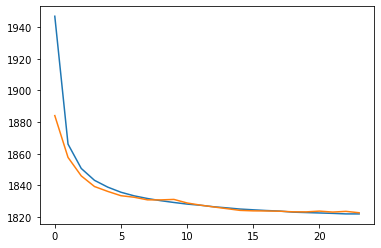

In [14]:
plt.plot(net.history["train_loss"])
plt.plot(net.history["val_loss"])

In [16]:
def visualize_reconstructions(model, input_imgs):
    # Reconstruct images
    model.eval()
    with torch.no_grad():
        reconst_imgs, mean, var = model(input_imgs.to(model.device))
    reconst_imgs = reconst_imgs.cpu()

    # Plotting
    imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0,1)
    grid = torchvision.utils.make_grid(imgs, nrow=8, normalize=True, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(20,20))
    plt.title(f"Actual image Vs Reconstructed image")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

In [17]:
def get_train_images(num):
    return torch.stack([train_data[i][0] for i in range(num)], dim=0)

In [18]:
input_imgs = get_train_images(32)

/home/fusemachines/.cache/pypoetry/virtualenvs/poetry-env-H-6CZZOK-py3.8/lib/python3.8/site-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


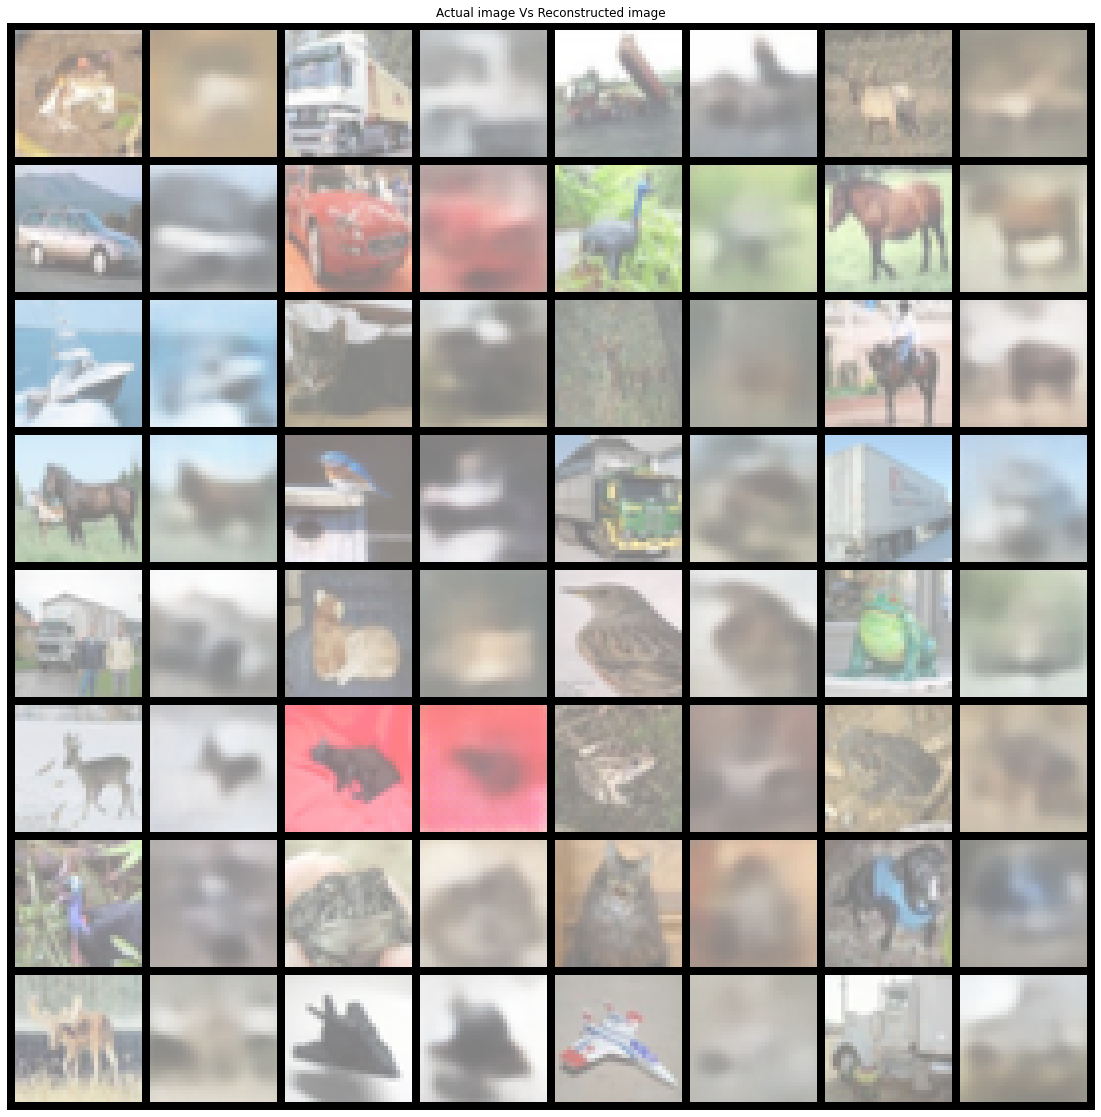

In [19]:
visualize_reconstructions(net, input_imgs)